In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve, plot_confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [2]:
df = pd.read_csv('complaints_2018_final.csv')

df.cmplnt_fr_dt = df.cmplnt_fr_dt.apply(lambda x: pd.to_datetime(x))

In [4]:
df.head()

cmplnt_num cmplnt_fr_dt cmplnt_fr_tm      rpt_dt  ky_cd      ofns_desc  \
0   453608592   2018-12-21     10:00 AM  2019-01-02    341  petit_larceny   
1   878647334   2018-10-17     14:30 PM  2019-01-15    341  petit_larceny   
2   128026914   2018-12-24     20:00 PM  2019-01-02    341  petit_larceny   
3   997752766   2018-09-17     07:00 AM  2019-01-07    112    theft_fraud   
4   746011851   2018-09-04     10:00 AM  2019-12-09    116     sex_crimes   

   pd_cd                         pd_desc   law_cat_cd    boro_nm  ...  \
0    338  larceny_petit_from_building_un  misdemeanor  manhattan  ...   
1    349  larceny_petit_of_license_plate  misdemeanor     queens  ...   
2    349  larceny_petit_of_license_plate  misdemeanor      bronx  ...   
3    739       fraud_unclassified_felony       felony   brooklyn  ...   
4    168                        sodomy_1       felony      bronx  ...   

  population          area    county zipcodes  adjusted_gross_income_(agi)  \
0    81305.0  2.628013e+07  New York  10002.0                    2002349.0   
1    98436.0  1.247863e+08    Queens  11385.0                    1929001.0   
2     4438.0  1.158795e+07     Bronx  10464.0                     163217.0   
3    77354.0  4.355518e+07     Kings  11204.0                    1606891.0   
4    97932.0  6.933617e+07     Bronx  10467.0                    1357285.0   

     avg_agi total_income_amount avg_total_income taxable_income_amount  \
0  46.126446           2033619.0        46.846786             1347603.0   
1  40.653340           1948325.0        41.060590             1141610.0   
2  76.269626            165381.0        77.280841              116220.0   
3  50.499403           1629709.0        51.216499              902117.0   
4  31.616236           1368864.0        31.885954              710802.0   

  avg_taxable_income  
0          52.867909  
1          34.149267  
2          66.034091  
3          47.680603  
4          25.819179  

[5 rows x 30 columns]

In [3]:
df = df[df.boro_nm != 'unknown']

In [6]:
df.cmplnt_num.nunique()

905671

In [7]:
df.shape

(916841, 30)

In [7]:
df.isnull().sum()

cmplnt_num                     0
cmplnt_fr_dt                   0
cmplnt_fr_tm                   0
rpt_dt                         0
ky_cd                          0
ofns_desc                      0
pd_cd                          0
pd_desc                        0
law_cat_cd                     0
boro_nm                        0
prem_typ_desc                  0
susp_age_group                 0
susp_race                      0
susp_sex                       0
latitude                       0
longitude                      0
patrol_boro                    0
vic_age_group                  0
vic_race                       0
vic_sex                        0
population                     0
area                           0
county                         0
zipcodes                       0
adjusted_gross_income_(agi)    0
avg_agi                        0
total_income_amount            0
avg_total_income               0
taxable_income_amount          0
avg_taxable_income             0
dtype: int

In [8]:
df.columns

Index(['cmplnt_num', 'cmplnt_fr_dt', 'cmplnt_fr_tm', 'rpt_dt', 'ky_cd',
       'ofns_desc', 'pd_cd', 'pd_desc', 'law_cat_cd', 'boro_nm',
       'prem_typ_desc', 'susp_age_group', 'susp_race', 'susp_sex', 'latitude',
       'longitude', 'patrol_boro', 'vic_age_group', 'vic_race', 'vic_sex',
       'population', 'area', 'county', 'zipcodes',
       'adjusted_gross_income_(agi)', 'avg_agi', 'total_income_amount',
       'avg_total_income', 'taxable_income_amount', 'avg_taxable_income'],
      dtype='object')

In [9]:
df.county.unique()

array(['New York', 'Queens', 'Bronx', 'Kings', 'Richmond'], dtype=object)

In [10]:
df.head()

cmplnt_num cmplnt_fr_dt cmplnt_fr_tm      rpt_dt  ky_cd      ofns_desc  \
0   453608592   2018-12-21     10:00 AM  2019-01-02    341  petit_larceny   
1   878647334   2018-10-17     14:30 PM  2019-01-15    341  petit_larceny   
2   128026914   2018-12-24     20:00 PM  2019-01-02    341  petit_larceny   
3   997752766   2018-09-17     07:00 AM  2019-01-07    112    theft_fraud   
4   746011851   2018-09-04     10:00 AM  2019-12-09    116     sex_crimes   

   pd_cd                         pd_desc   law_cat_cd    boro_nm  ...  \
0    338  larceny_petit_from_building_un  misdemeanor  manhattan  ...   
1    349  larceny_petit_of_license_plate  misdemeanor     queens  ...   
2    349  larceny_petit_of_license_plate  misdemeanor      bronx  ...   
3    739       fraud_unclassified_felony       felony   brooklyn  ...   
4    168                        sodomy_1       felony      bronx  ...   

           area    county zipcodes adjusted_gross_income_(agi)    avg_agi  \
0  2.628013e+07  New York  10002.0                   2002349.0  46.126446   
1  1.247863e+08    Queens  11385.0                   1929001.0  40.653340   
2  1.158795e+07     Bronx  10464.0                    163217.0  76.269626   
3  4.355518e+07     Kings  11204.0                   1606891.0  50.499403   
4  6.933617e+07     Bronx  10467.0                   1357285.0  31.616236   

   total_income_amount avg_total_income taxable_income_amount  \
0            2033619.0        46.846786             1347603.0   
1            1948325.0        41.060590             1141610.0   
2             165381.0        77.280841              116220.0   
3            1629709.0        51.216499              902117.0   
4            1368864.0        31.885954              710802.0   

  avg_taxable_income     crime_type  
0          52.867909  petit_larceny  
1          34.149267  petit_larceny  
2          66.034091  petit_larceny  
3          47.680603    theft_fraud  
4          25.819179     sex_crimes  

[5 rows x 31 columns]

## EDA - correlation to neighborhood
---

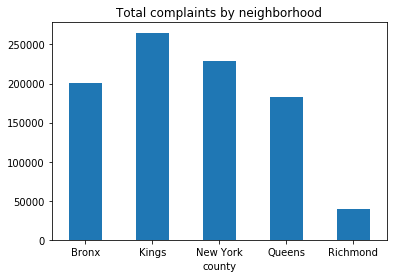

In [14]:
complaints_by_neighborhood = df.groupby('county').cmplnt_num.count()
complaints_by_neighborhood.plot.bar(rot = 0)
plt.title('Total complaints by neighborhood');

Text(0.5, 1.0, 'Total Population of each Area')

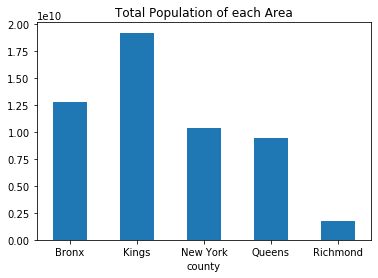

In [15]:
neighborhood_pop = df.groupby('county').population.sum()
neighborhood_pop.plot.bar(rot = 0)
plt.title('Total Population of each Area')

In [16]:
neighborhood_pop

county
Bronx       1.283351e+10
Kings       1.922689e+10
New York    1.038904e+10
Queens      9.423313e+09
Richmond    1.760492e+09
Name: population, dtype: float64

In [17]:
broken_down_complaints = df.groupby(['ofns_desc', 'boro_nm']).cmplnt_num.count()

In [18]:
complaints_df = broken_down_complaints.unstack()

complaints_df

boro_nm                               bronx  brooklyn  manhattan  queens  \
ofns_desc                                                                  
abortion                                1.0       NaN        NaN     NaN   
administrative_code                   682.0     585.0      271.0   498.0   
agriculture_&_mrkts_lawunclassified    70.0      68.0       57.0    55.0   
alcoholic_beverage_control_law         51.0     130.0       16.0    18.0   
anticipatory_offenses                   2.0       3.0        4.0     3.0   
...                                     ...       ...        ...     ...   
theft_of_services                     143.0     104.0      487.0    82.0   
unauthorized_use_of_a_vehicle         450.0    1072.0      359.0  1190.0   
unknown                                 4.0       4.0       12.0     1.0   
unlawful_poss_weap_on_school            NaN       1.0        1.0     3.0   
vehicle_and_traffic_laws             3283.0    3996.0     2312.0  3428.0   

boro_nm                              staten_island  
ofns_desc                                           
abortion                                       NaN  
administrative_code                           79.0  
agriculture_&_mrkts_lawunclassified           20.0  
alcoholic_beverage_control_law                 1.0  
anticipatory_offenses                          NaN  
...                                            ...  
theft_of_services                              NaN  
unauthorized_use_of_a_vehicle                156.0  
unknown                                        1.0  
unlawful_poss_weap_on_school                   NaN  
vehicle_and_traffic_laws                     355.0  

[65 rows x 5 columns]

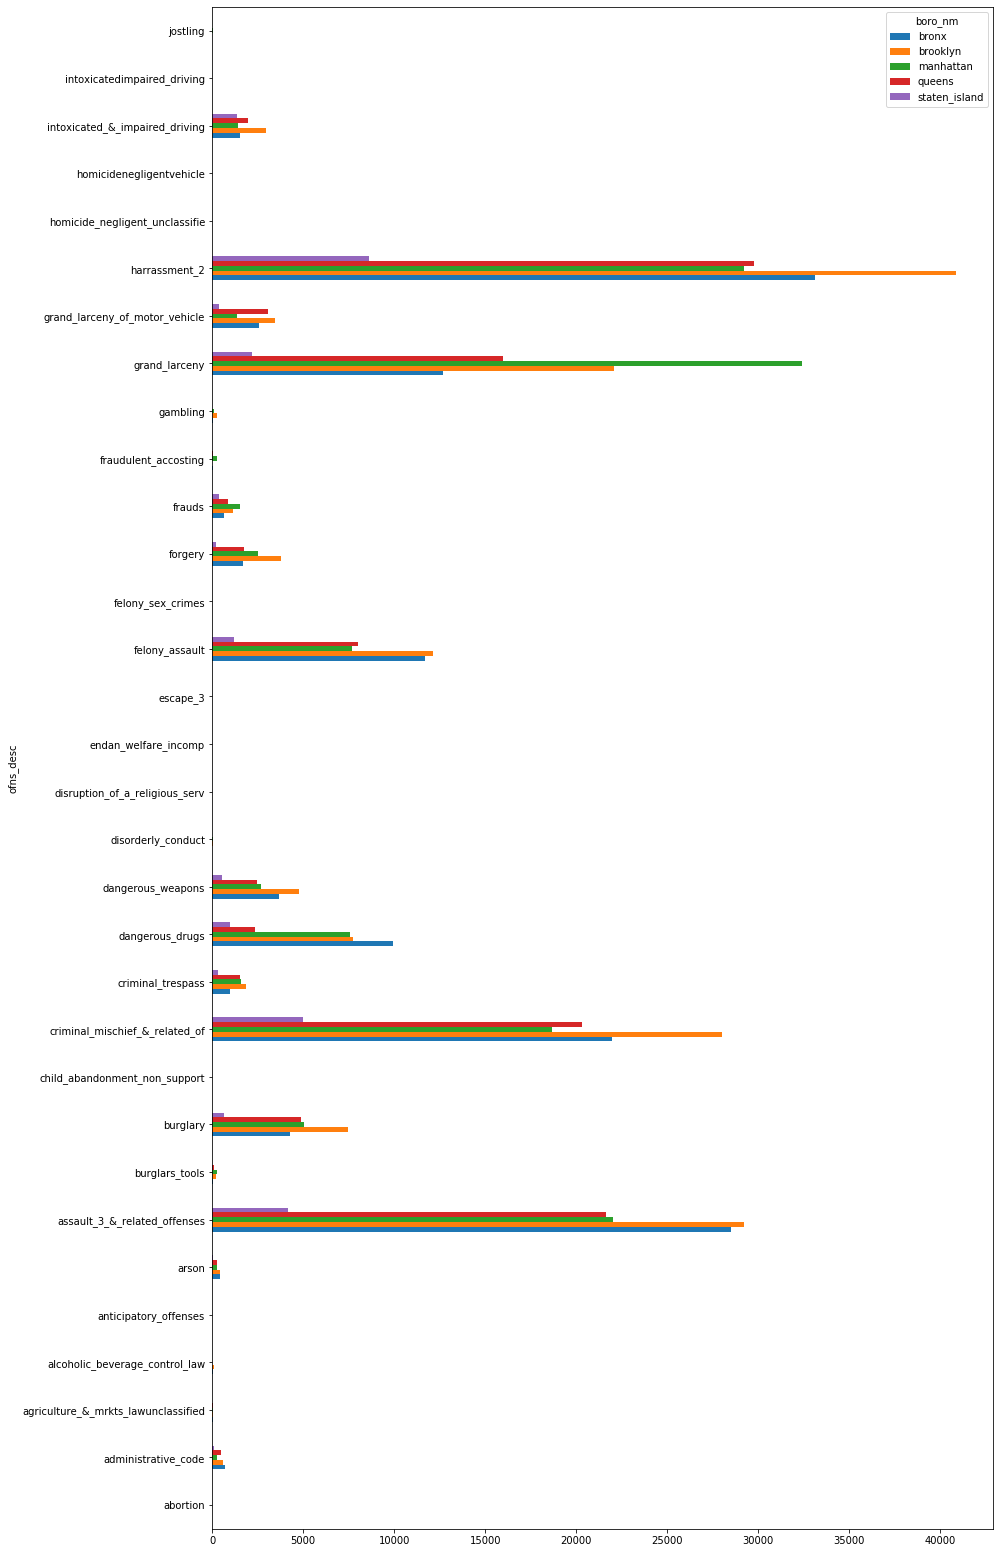

In [19]:
complaints_df[:len(complaints_df) // 2].plot.barh(figsize = (14,28), rot = 0)

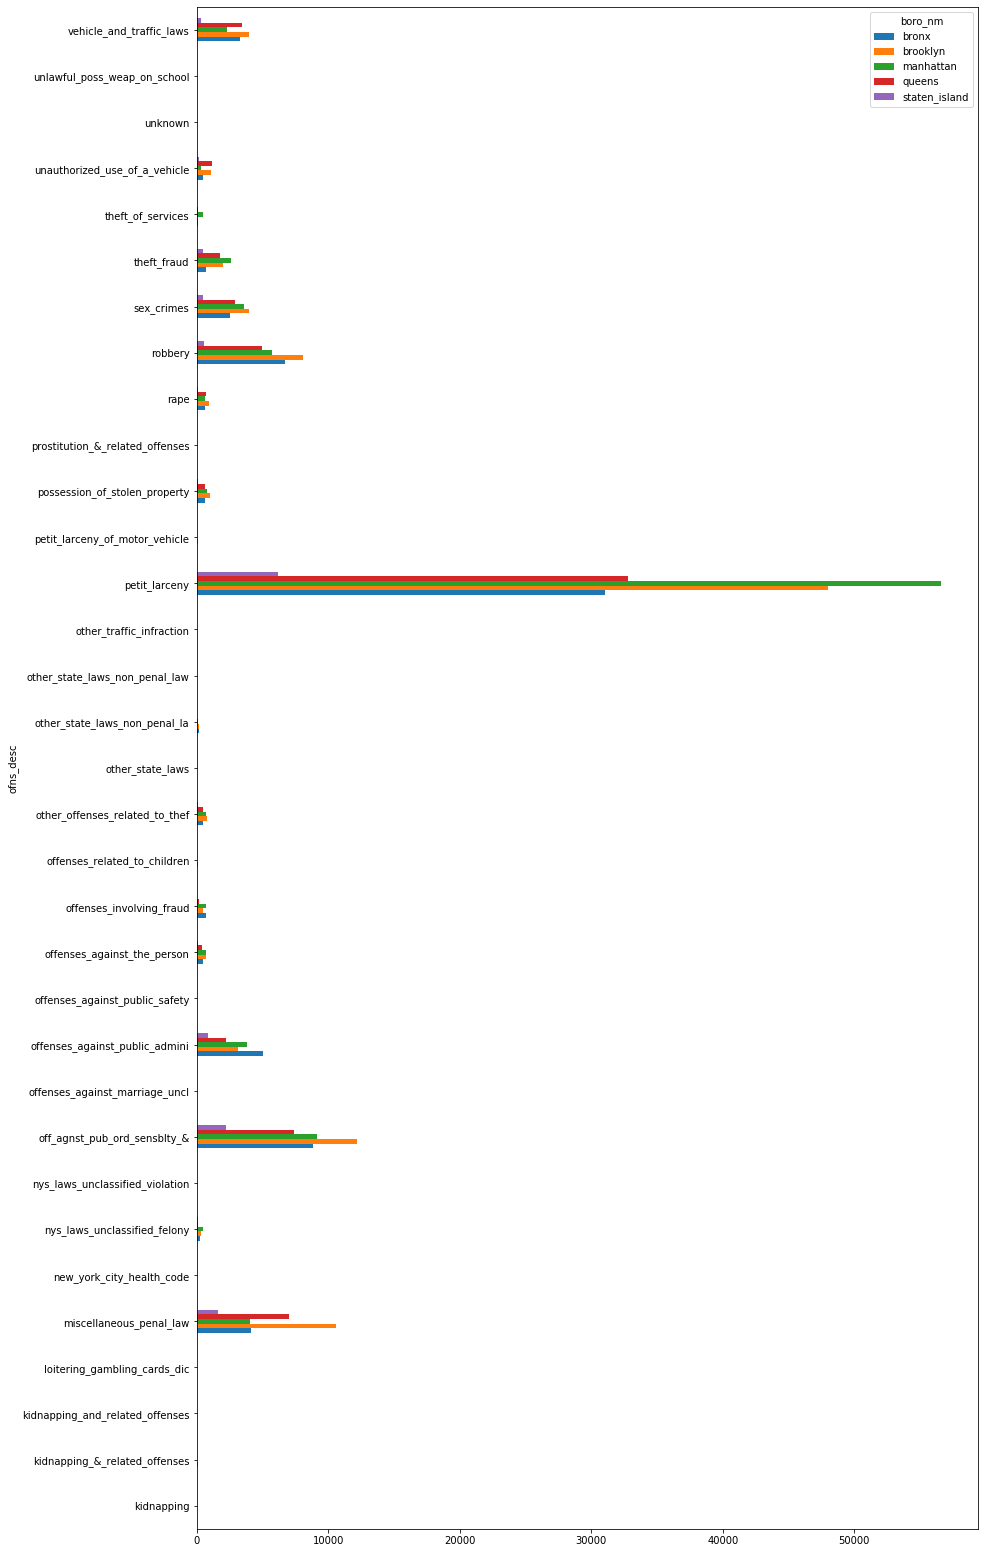

In [20]:
complaints_df[len(complaints_df) // 2:].plot.barh(figsize = (14,28), rot = 0)

In [21]:
df.ofns_desc.nunique(), df.pd_desc.nunique()

(65, 368)

Look at timing of crimes (month, day, week, etc) to see if there are more activities in different districts.

In [4]:
df['dayofweek'] = df.cmplnt_fr_dt.apply(lambda x: x.day_name())

In [5]:
df['month'] = df.cmplnt_fr_dt.apply(lambda x: x.month)

In [24]:
df.head()

cmplnt_num cmplnt_fr_dt cmplnt_fr_tm      rpt_dt  ky_cd      ofns_desc  \
0   453608592   2018-12-21     10:00 AM  2019-01-02    341  petit_larceny   
1   878647334   2018-10-17     14:30 PM  2019-01-15    341  petit_larceny   
2   128026914   2018-12-24     20:00 PM  2019-01-02    341  petit_larceny   
3   997752766   2018-09-17     07:00 AM  2019-01-07    112    theft_fraud   
4   746011851   2018-09-04     10:00 AM  2019-12-09    116     sex_crimes   

   pd_cd                         pd_desc   law_cat_cd    boro_nm  ...  \
0    338  larceny_petit_from_building_un  misdemeanor  manhattan  ...   
1    349  larceny_petit_of_license_plate  misdemeanor     queens  ...   
2    349  larceny_petit_of_license_plate  misdemeanor      bronx  ...   
3    739       fraud_unclassified_felony       felony   brooklyn  ...   
4    168                        sodomy_1       felony      bronx  ...   

  adjusted_gross_income_(agi)    avg_agi total_income_amount avg_total_income  \
0                   2002349.0  46.126446           2033619.0        46.846786   
1                   1929001.0  40.653340           1948325.0        41.060590   
2                    163217.0  76.269626            165381.0        77.280841   
3                   1606891.0  50.499403           1629709.0        51.216499   
4                   1357285.0  31.616236           1368864.0        31.885954   

   taxable_income_amount  avg_taxable_income     crime_type crime_num  \
0              1347603.0           52.867909  petit_larceny      None   
1              1141610.0           34.149267  petit_larceny      None   
2               116220.0           66.034091  petit_larceny      None   
3               902117.0           47.680603    theft_fraud      None   
4               710802.0           25.819179     sex_crimes      None   

   dayofweek month  
0     Friday    12  
1  Wednesday    10  
2     Monday    12  
3     Monday     9  
4    Tuesday     9  

[5 rows x 34 columns]

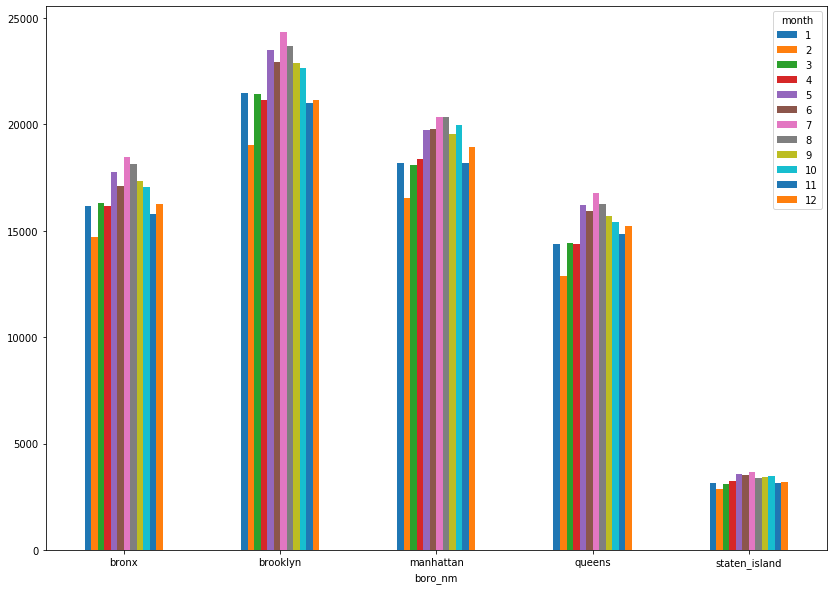

In [25]:
df.groupby(['boro_nm','month']).cmplnt_num.count().unstack().plot.bar(figsize = (14, 10), rot = 0)

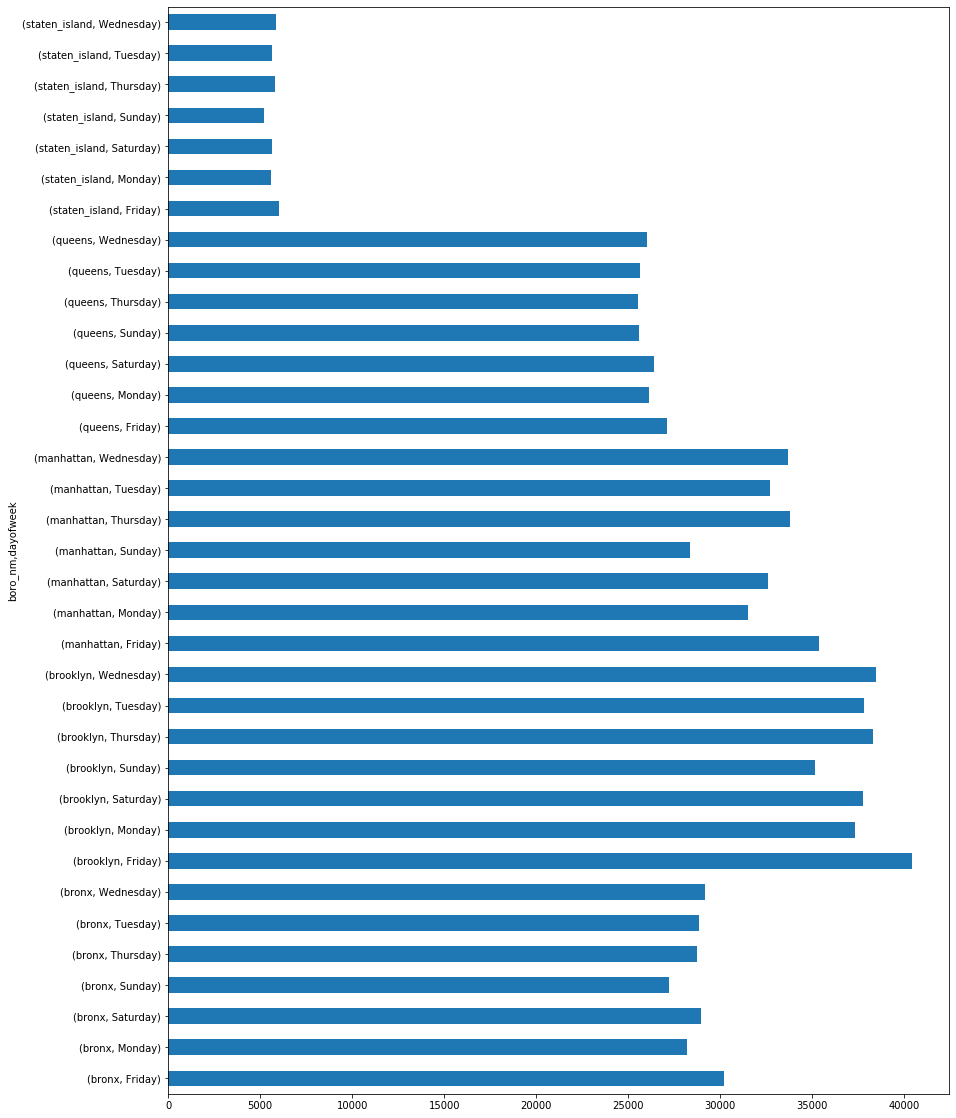

In [26]:
df.groupby(['boro_nm','dayofweek']).cmplnt_num.count().plot.barh(figsize = (14, 20))

In [27]:
df.columns

Index(['cmplnt_num', 'cmplnt_fr_dt', 'cmplnt_fr_tm', 'rpt_dt', 'ky_cd',
       'ofns_desc', 'pd_cd', 'pd_desc', 'law_cat_cd', 'boro_nm',
       'prem_typ_desc', 'susp_age_group', 'susp_race', 'susp_sex', 'latitude',
       'longitude', 'patrol_boro', 'vic_age_group', 'vic_race', 'vic_sex',
       'population', 'area', 'county', 'zipcodes',
       'adjusted_gross_income_(agi)', 'avg_agi', 'total_income_amount',
       'avg_total_income', 'taxable_income_amount', 'avg_taxable_income',
       'crime_type', 'crime_num', 'dayofweek', 'month'],
      dtype='object')

In [28]:
df.boro_nm.unique()

array(['manhattan', 'queens', 'bronx', 'brooklyn', 'staten_island'],
      dtype=object)

It is important to stipulate that the following is NOT an indicator of who is actually committing more crimes, as these are merely complaints of crime, not necessarily arrests or convictions. 
However, the distribution in the data here might still be useful for modelling purposes.

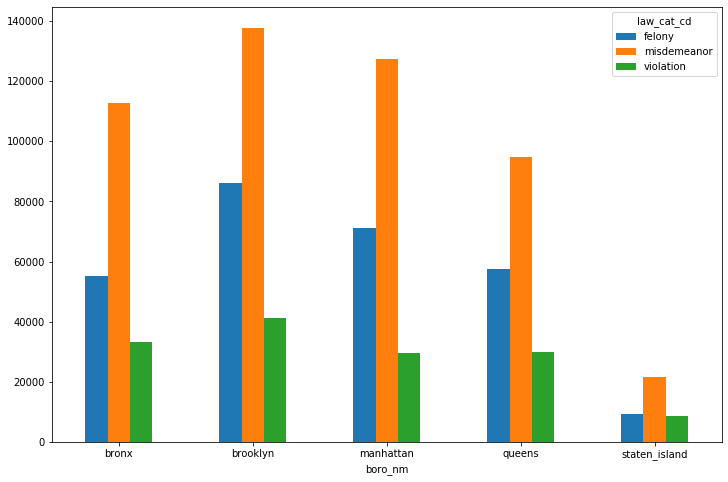

In [29]:
df.groupby(['boro_nm', 'law_cat_cd']).cmplnt_num.count().unstack().plot.bar(figsize = (12, 8), rot = 0);

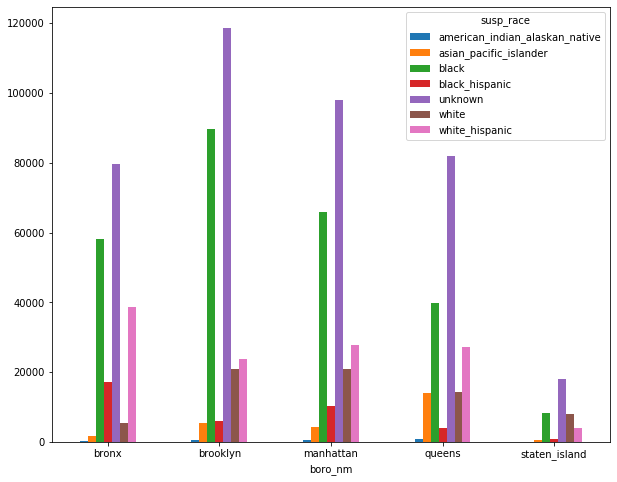

In [30]:
df.groupby(['boro_nm', 'susp_race']).cmplnt_num.count().unstack().plot.bar(figsize = (10, 8), rot = 0);

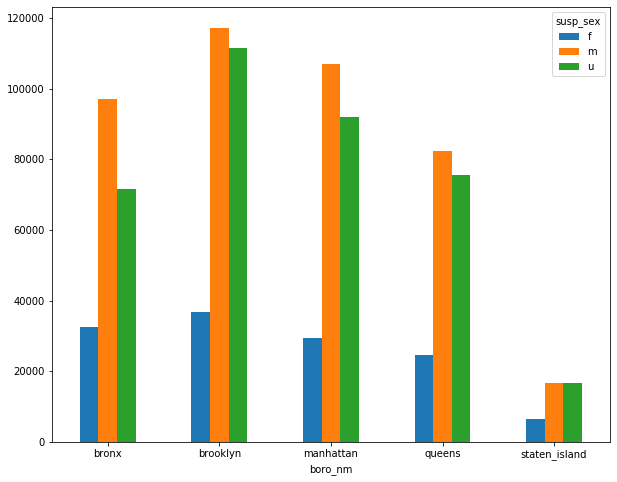

In [31]:
df.groupby(['boro_nm', 'susp_sex']).cmplnt_num.count().unstack().plot.bar(figsize = (10, 8), rot = 0);

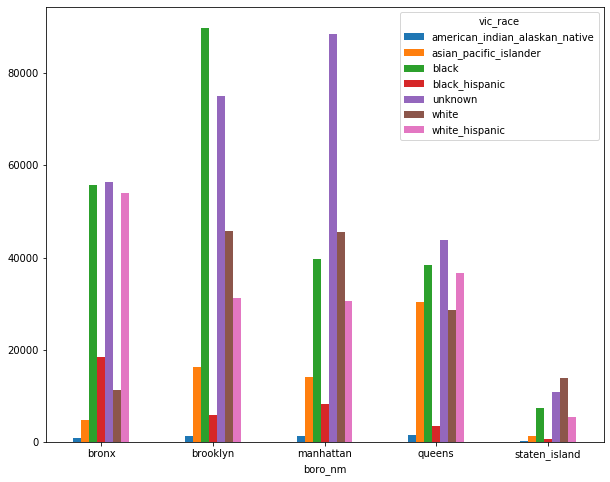

In [32]:
df.groupby(['boro_nm', 'vic_race']).cmplnt_num.count().unstack().plot.bar(figsize = (10, 8), rot = 0);

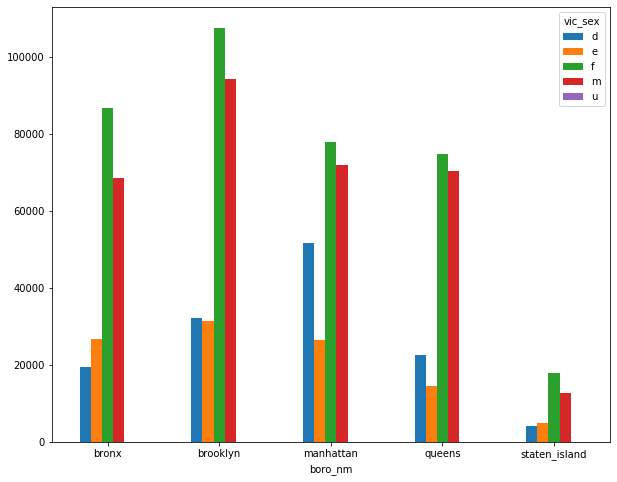

In [33]:
df.groupby(['boro_nm', 'vic_sex']).cmplnt_num.count().unstack().plot.bar(figsize = (10, 8), rot = 0);

Below is less for interpretation, but for a visual of potential signal that can differentiate county location:

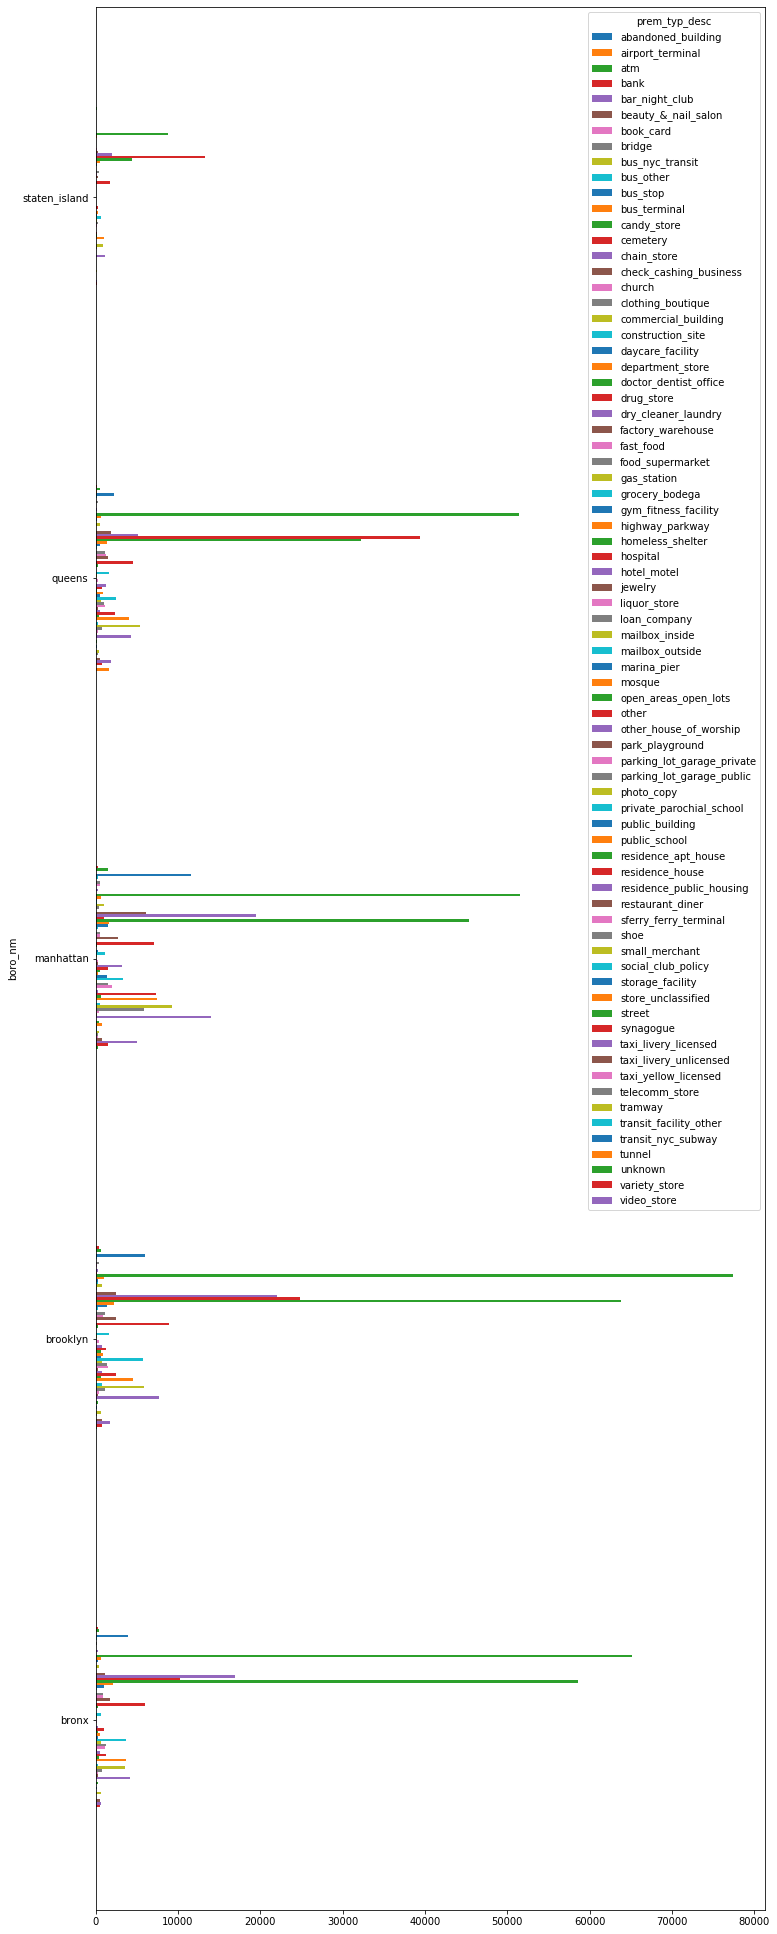

In [34]:
df.groupby(['boro_nm', 'prem_typ_desc']).cmplnt_num.count().unstack().plot.barh(figsize = (12, 35));

## Processing Features
---

In [35]:
df.columns

Index(['cmplnt_num', 'cmplnt_fr_dt', 'cmplnt_fr_tm', 'rpt_dt', 'ky_cd',
       'ofns_desc', 'pd_cd', 'pd_desc', 'law_cat_cd', 'boro_nm',
       'prem_typ_desc', 'susp_age_group', 'susp_race', 'susp_sex', 'latitude',
       'longitude', 'patrol_boro', 'vic_age_group', 'vic_race', 'vic_sex',
       'population', 'area', 'county', 'zipcodes',
       'adjusted_gross_income_(agi)', 'avg_agi', 'total_income_amount',
       'avg_total_income', 'taxable_income_amount', 'avg_taxable_income',
       'crime_type', 'crime_num', 'dayofweek', 'month'],
      dtype='object')

In [6]:
df.boro_nm.unique()

array(['manhattan', 'queens', 'bronx', 'brooklyn', 'staten_island'],
      dtype=object)

In [7]:
features = ['ofns_desc', 'pd_desc', 'prem_typ_desc', 'susp_race', 'susp_sex', 'vic_race', 'vic_sex', 'dayofweek']
X = df[features]
y = df.boro_nm

In [8]:
coder = LabelEncoder()
coder.fit(y)

y_code = coder.transform(y)

In [9]:
y_code, y

(array([2, 3, 0, ..., 2, 2, 1]), 0         manhattan
 1            queens
 2             bronx
 3          brooklyn
 4             bronx
             ...    
 917451    manhattan
 917452        bronx
 917453    manhattan
 917454    manhattan
 917455     brooklyn
 Name: boro_nm, Length: 916841, dtype: object)

In [10]:
X.shape, y.shape

((916841, 8), (916841,))

In [11]:
#Dummy basically everything, since it's all categorical
X = pd.get_dummies(X, columns = X.columns, drop_first = True)

In [12]:
y.value_counts(normalize = True)

brooklyn         0.289285
manhattan        0.248779
bronx            0.219580
queens           0.198957
staten_island    0.043399
Name: boro_nm, dtype: float64

In [13]:
#No need to scale, everything is binarized.

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [14]:
#Evaluation functions to use - get tp, fn, tn and fp from a confusion matrix!
def sensitivity(tp, fn):
    return tp / (tp + fn)

def specificity(tn, fp):
    return tn / (tn + fp)

def precision(tp, fp):
    return tp / (tp + fp)

In [15]:
def make_metrics(model, X_test, y_test, test_preds = None):
    #Neural network models will "predict" probabilities, so I am allowing for that possibility
    if not test_preds: 
        test_preds = model.predict(X_test)
    matrix = confusion_matrix(y_test, test_preds)
    #Building for each class in a multi-class classification model
    bronxtp = matrix[0][0]
    bronxfp = np.sum(matrix[:,0][1:])
    bronxfn = np.sum(matrix[0,:][1:])
    bronxtn = np.sum(matrix) - bronxtp - bronxfp - bronxfn
    
    brooklyntp = matrix[1][1]
    brooklynfp = matrix[0][1] +np.sum(matrix[:,1][2:])
    brooklynfn = matrix[1][0] + np.sum(matrix[1,:][2:])
    brooklyntn = np.sum(matrix) - brooklyntp - brooklynfp - brooklynfn
    
    manhattantp = matrix[2][2]
    manhattanfp = matrix[0][1] + matrix[2][1] + matrix[3][1] + matrix[4][1]
    manhattanfn = matrix[1][0] + matrix[1][2] + matrix[1][3] + matrix[1][4]
    manhattantn = np.sum(matrix) - manhattantp - manhattanfp - manhattanfn
    
    queenstp = matrix[3][3]
    queensfp = np.sum(matrix[:,3][:3]) + matrix[:,3][4]
    queensfn = np.sum(matrix[3,:3]) + matrix[3][4]
    queenstn = np.sum(matrix) - queenstp - queensfp - queensfn
    
    stitp = matrix[4][4]
    stifp = np.sum(matrix[:,4][:4])
    stifn = np.sum(matrix[4,:][:4])
    stitn = np.sum(matrix) - stitp - stifp - stifn
    
    print(f'Metrics for the Bronx with {model}')
    print('----\n')
    print(f'Sensitivity:{sensitivity(bronxtp, bronxfn)}')
    print(f'Specificity:{specificity(bronxtn, bronxfp)}')
    print(f'Precision:{precision(bronxtp, bronxfp)}\n')
    
    print(f'Metrics for Brooklyn with {model}')
    print('----\n')
    print(f'Sensitivity:{sensitivity(brooklyntp, brooklynfn)}')
    print(f'Specificity:{specificity(brooklyntn, brooklynfp)}')
    print(f'Precision:{precision(brooklyntp, brooklynfp)}\n')
    
    print(f'Metrics for Manhattan with {model}')
    print('----\n')
    print(f'Sensitivity:{sensitivity(manhattantp, manhattanfn)}')
    print(f'Specificity:{specificity(manhattantn, manhattanfp)}')
    print(f'Precision:{precision(manhattantp, manhattanfp)}\n')
    
    print(f'Metrics for Queens with {model}')
    print('----\n')
    print(f'Sensitivity:{sensitivity(queenstp, queensfn)}')
    print(f'Specificity:{specificity(queenstn, queensfp)}')
    print(f'Precision:{precision(queenstp, queensfp)}\n')
    
    print(f'Metrics for Staten Island with {model}')
    print('----\n')
    print(f'Sensitivity:{sensitivity(stitp, stifn)}')
    print(f'Specificity:{specificity(stitn, stifp)}')
    print(f'Precision:{precision(stitp, stifp)}\n')

## Logistic Regressor
---

I do not anticipate high performance with a logistic regressor, as it is generally intended for binary classification.

In [159]:
%%time
logreg = LogisticRegression(max_iter = 1000, multi_class = 'multinomial')
logreg.fit(X_train, y_train)

CPU times: user 52min 50s, sys: 3min 48s, total: 56min 38s
Wall time: 16min 16s


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [160]:
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.4316100228320463, 0.42947328007818125)

In [161]:
train_preds = logreg.predict(X_train)
test_preds = logreg.predict(X_test)

Text(0.5, 1.0, 'Performance of Logisitic Regression Classifier on Seen Data')

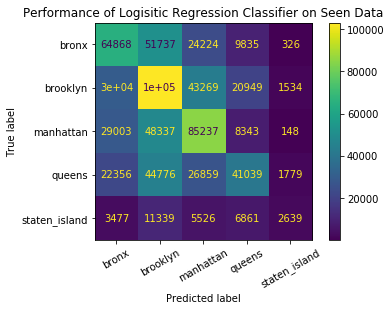

In [163]:
plot_confusion_matrix(logreg, X_train, y_train, xticks_rotation = 30)
plt.title('Performance of Logisitic Regression Classifier on Seen Data')

Text(0.5, 1.0, 'Performance of Logistic Regression Classifier on Unseen Data')

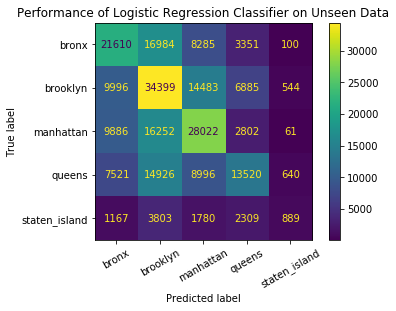

In [164]:
plot_confusion_matrix(logreg, X_test, y_test, xticks_rotation = 30)
plt.title('Performance of Logistic Regression Classifier on Unseen Data')

In [165]:
make_metrics(logreg, X_test, y_test)

Metrics for the Bronx with LogisticRegression(max_iter=1000, multi_class='multinomial')
----

Sensitivity:0.4293661831909398
Specificity:0.8402848821283423
Precision:0.4306496612196094

Metrics for Brooklyn with LogisticRegression(max_iter=1000, multi_class='multinomial')
----

Sensitivity:0.518783838810382
Specificity:0.6810084466925306
Precision:0.398302533463017

Metrics for Manhattan with LogisticRegression(max_iter=1000, multi_class='multinomial')
----

Sensitivity:0.4675788419823127
Specificity:0.6930252066091293
Precision:0.3503319289384525

Metrics for Queens with LogisticRegression(max_iter=1000, multi_class='multinomial')
----

Sensitivity:0.2964717233515339
Specificity:0.9164143174589342
Precision:0.4683548688814217

Metrics for Staten Island with LogisticRegression(max_iter=1000, multi_class='multinomial')
----

Sensitivity:0.08936469642139123
Specificity:0.9938658141136444
Precision:0.39794091316025065



## Random Forest
---

In [45]:
rf = RandomForestClassifier(n_estimators = 125, min_samples_leaf = 25)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=25, n_estimators=125)

In [46]:
rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.4387955732007039, 0.4342156353752656)

In [71]:
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

Text(0.5, 1.0, 'Performance of Random Forest Classifier on Seen Data')

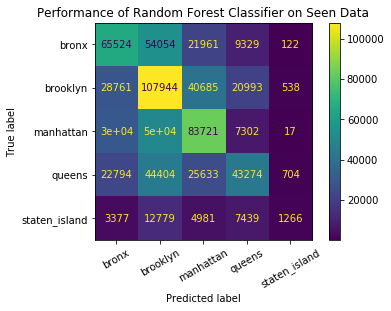

In [74]:
plot_confusion_matrix(rf, X_train, y_train, xticks_rotation = 30)
plt.title('Performance of Random Forest Classifier on Seen Data')

Text(0.5, 1.0, 'Performance of Random Forest Classifier on Unseen Data')

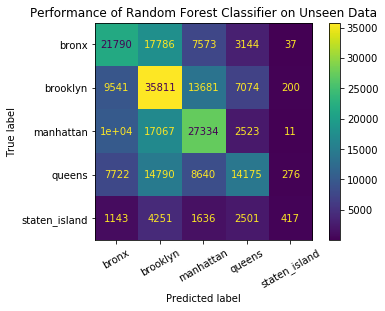

In [75]:
plot_confusion_matrix(rf, X_test, y_test, xticks_rotation = 30)
plt.title('Performance of Random Forest Classifier on Unseen Data')

In [157]:
make_metrics(rf, X_test, y_test)

Metrics for the Bronx with RandomForestClassifier(min_samples_leaf=25, n_estimators=125)
----

Sensitivity:0.43294257897874033
Specificity:0.8407097455850537
Precision:0.43333863654442767

Metrics for Brooklyn with RandomForestClassifier(min_samples_leaf=25, n_estimators=125)
----

Sensitivity:0.5400787247198636
Specificity:0.6691671168295438
Precision:0.39920851680508335

Metrics for Manhattan with RandomForestClassifier(min_samples_leaf=25, n_estimators=125)
----

Sensitivity:0.4726612484869445
Specificity:0.6855310682047602
Precision:0.33650957797803716

Metrics for Queens with RandomForestClassifier(min_samples_leaf=25, n_estimators=125)
----

Sensitivity:0.3108348134991119
Specificity:0.916986187965666
Precision:0.4818642281673862

Metrics for Staten Island with RandomForestClassifier(min_samples_leaf=25, n_estimators=125)
----

Sensitivity:0.04191797346200241
Specificity:0.9976101759074718
Precision:0.44314558979808716



## Gradient Boosted Tree Model
---

In [17]:
gboost = GradientBoostingClassifier(n_estimators=125, learning_rate=0.04, max_depth=6, min_samples_leaf=30)

In [18]:
%%time
gboost.fit(X_train, y_train)

CPU times: user 2h 15min 4s, sys: 33.2 s, total: 2h 15min 37s
Wall time: 2h 15min 43s


GradientBoostingClassifier(learning_rate=0.04, max_depth=6, min_samples_leaf=30,
                           n_estimators=125)

In [19]:
gboost.score(X_train, y_train), gboost.score(X_test, y_test)

(0.4318717915157861, 0.42973941041224023)

## Neural Network
---

In [231]:
X_test.values.shape

(229211, 529)

In [16]:
y_train_code = coder.transform(y_train)
y_test_code = coder.transform(y_test)

In [17]:
y_train_code = to_categorical(y_train_code, 5)
y_test_code = to_categorical(y_test_code, 5)

In [18]:
y_test_code.shape, X_test.shape

((229211, 5), (229211, 529))

In [22]:
model = Sequential()

model.add(Dense(8000, activation = 'relu', kernel_regularizer = l2(0.002), input_dim = 529))

model.add(Dense(4000, activation = 'relu', kernel_regularizer = l2(0.002)))

model.add(Dense(2000, activation = 'relu', kernel_regularizer = l2(0.002)))

#model.add(Dense(1000, activation = 'relu', kernel_regularizer = l2(0.005)))

model.add(Dense(500, activation = 'relu', kernel_regularizer = l2(0.002)))

model.add(Dense(250, activation = 'relu', kernel_regularizer = l2(0.002)))

model.add(Dense(70, activation = 'relu', kernel_regularizer = l2(0.002)))

model.add(Dense(5, activation = 'softmax', kernel_regularizer = l2(0.002)))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [23]:
result = model.fit(X_train.values, y_train_code, batch_size = 2500, validation_data = (X_test.values, y_test_code), epochs = 15)

Epoch 1/15
276/276 [==============================] - 842s 3s/step - loss: 2.1758 - accuracy: 0.3932 - val_loss: 1.4281 - val_accuracy: 0.4192
Epoch 2/15
276/276 [==============================] - 833s 3s/step - loss: 1.4188 - accuracy: 0.4203 - val_loss: 1.4066 - val_accuracy: 0.4261
Epoch 3/15
276/276 [==============================] - 846s 3s/step - loss: 1.4063 - accuracy: 0.4235 - val_loss: 1.4046 - val_accuracy: 0.4225
Epoch 4/15
276/276 [==============================] - 814s 3s/step - loss: 1.4014 - accuracy: 0.4251 - val_loss: 1.4077 - val_accuracy: 0.4206
Epoch 5/15
276/276 [==============================] - 816s 3s/step - loss: 1.3993 - accuracy: 0.4255 - val_loss: 1.3988 - val_accuracy: 0.4246
Epoch 6/15
276/276 [==============================] - 794s 3s/step - loss: 1.3968 - accuracy: 0.4269 - val_loss: 1.3957 - val_accuracy: 0.4267
Epoch 7/15
276/276 [==============================] - 823s 3s/step - loss: 1.3950 - accuracy: 0.4273 - val_loss: 1.4051 - val_accuracy: 0.4219